Preparar o dataset 

Reading the ARFF file

In [97]:
from scipy.io.arff import loadarff
import pandas as pd, numpy as np

data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

Separate input from output data 

In [98]:
features = df.drop('class', axis=1)
target = df['class']

Apply a 10-fold stratified cross-validation with shuffling (random_state=0)

In [99]:
from sklearn.model_selection import StratifiedKFold

acc_folds_gauss = []
acc_folds_knn = []
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

**Exercise 1**
**a)**

Create 𝑘NN with 𝑘 = 5 and naive Bayes with Gaussian assumption. It is necessary to perform the for loop 10 times because there are 10 splits in StratifiedKFold. Train both predictors and compare both lists of accuracies. Each list has 10 accuracies, one per iteration.

In [100]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gaussNB = GaussianNB()
knn_predictor = KNeighborsClassifier(n_neighbors=5)

# iterate per fold
for train_k, test_k in folds.split(features, target):
    X_train, X_test = features.iloc[train_k], features.iloc[test_k]
    y_train, y_test = target.iloc[train_k], target.iloc[test_k]
    
    ## train and assess
    gaussNB.fit(X_train, y_train)
    y_pred_gauss = gaussNB.predict(X_test)
    acc_folds_gauss.append(round(metrics.accuracy_score(y_test, y_pred_gauss),4))
    
    knn_predictor.fit(X_train, y_train)
    y_pred_knn = knn_predictor.predict(X_test)
    acc_folds_knn.append(round(metrics.accuracy_score(y_test, y_pred_knn),4))

print("Fold accuracies GaussianNB:", acc_folds_gauss)
print("Fold accuracies kNN:", acc_folds_knn)

Fold accuracies GaussianNB: [0.8387, 0.871, 0.8387, 0.871, 0.7742, 0.8387, 0.9032, 0.8065, 0.7742, 0.7097]
Fold accuracies kNN: [0.9355, 0.8065, 0.871, 0.9355, 0.7419, 0.871, 0.8387, 0.8387, 0.7742, 0.7742]


Plot the boxplot to see the differences

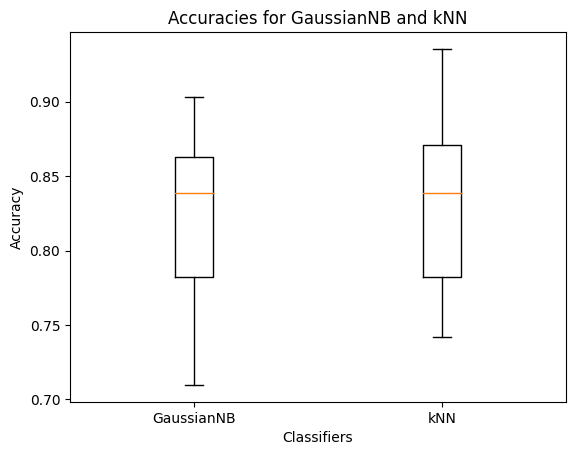

In [101]:
import matplotlib.pyplot as plt

plt.boxplot([acc_folds_gauss, acc_folds_knn], labels=['GaussianNB', 'kNN'])
plt.title('Accuracies for GaussianNB and kNN')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

**b)**

In [102]:
from scipy import stats

hypothesis = stats.ttest_rel(acc_folds_knn, acc_folds_gauss, alternative='greater')

if hypothesis[1] < 0.05:
    print("The null hypothesis is rejected and kNN is statistically superior to GaussianNB")
    
else:
    print("The null hypothesis is not rejected and there is no statistical evidence that kNN is superior to GaussianNB")
    
print("p-value:", hypothesis[1])

The null hypothesis is not rejected and there is no statistical superiority between kNN and GaussianNB
p-value: 0.19041747375669454


**Exercise 2**

Initialize the cumulative confusion matrices. In the for loop, create, train and predict test observations for both predictors.
Create confusion matrices per iteration and sum them to the cumulative confusion matrix.

In [103]:
from sklearn.metrics import confusion_matrix

cum_conf_matrix1 = np.zeros((3,3))
cum_conf_matrix5 = np.zeros((3,3))

for train_k, test_k in folds.split(features, target):
    X_train, X_test = features.iloc[train_k], features.iloc[test_k]
    y_train, y_test = target.iloc[train_k], target.iloc[test_k]
    
    knn1 = KNeighborsClassifier(n_neighbors=1,weights='uniform',metric='euclidean')
    knn5 = KNeighborsClassifier(n_neighbors=5,weights='uniform',metric='euclidean')

    knn1.fit(X_train, y_train)
    knn5.fit(X_train, y_train)

    y_pred1 = knn1.predict(X_test)
    y_pred5 = knn5.predict(X_test)
    
    conf_matrix1 = confusion_matrix(y_test, y_pred1)
    conf_matrix5 = confusion_matrix(y_test, y_pred5)

    cum_conf_matrix1 += conf_matrix1
    cum_conf_matrix5 += conf_matrix5

Calculate the difference between the two confusion matrices and shou that matrix in a Data Frame

In [104]:
conf_matrix_diff = cum_conf_matrix1 - cum_conf_matrix5

confusion1 = pd.DataFrame(conf_matrix_diff, index=knn1.classes_, columns=['Predicted Hernia', 'Predicted Normal', 'Predicted Spondylolisthesis'])
print(confusion1)

                   Predicted Hernia  Predicted Normal  \
Hernia                         -2.0               2.0   
Normal                         -5.0               2.0   
Spondylolisthesis               0.0               1.0   

                   Predicted Spondylolisthesis  
Hernia                                     0.0  
Normal                                     3.0  
Spondylolisthesis                         -1.0  


Create the heatmap with a color bar and numerical values within each cell

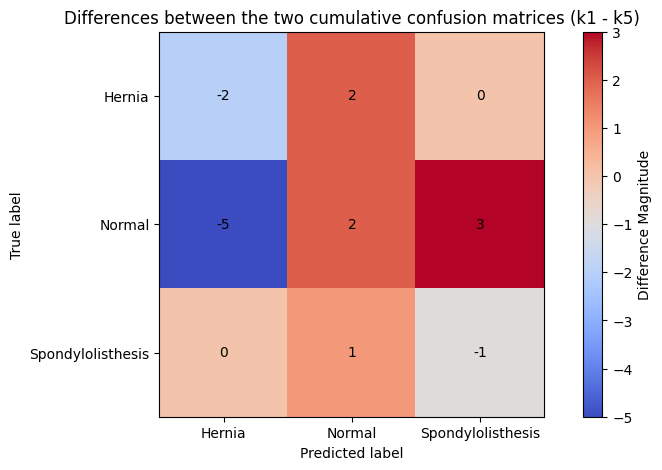

In [105]:
plt.figure(figsize=(10, 5))
heatmap = plt.imshow(conf_matrix_diff,cmap="coolwarm", interpolation='nearest')
plt.title('Differences between the two cumulative confusion matrices (k1 - k5)')
plt.xlabel('Predicted label')
plt.xticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.yticks([0, 1, 2], ['Hernia', 'Normal', 'Spondylolisthesis'])
plt.ylabel('True label')


cbar = plt.colorbar(heatmap)
cbar.set_label('Difference Magnitude', rotation=90)

for i in range(conf_matrix_diff.shape[0]):
    for j in range(conf_matrix_diff.shape[1]):
        plt.text(j, i, str(int(conf_matrix_diff[i, j])), ha='center', va='center', color='black')

plt.show()

On the diagonal, a value equal to zero indicates that both classifiers had the same number of correct classifications in those classes. If the value is positive, kNN with k=1 (kNN1) had a greater number of correct classifications, and if the value is negative, the other classifier (kNN5) had a greater number of correct classifications. If the values off the diagonal are positive, it indicates that kNN1 made more frequent errors, and if they are negative, it implies the opposite.

For this specific case, it is possible to infer that kNN1 works better for the Normal class, while kNN5 achieved more correct classifications for the Hernia and Spondylolisthesis classes. It is important to highlight that kNN5 has difficulty classifying observations that should be Normal, misclassifying them as Hernia.

**Exercise 3**

Three possible difficulties of naive Bayes are:

1- The dataset is not normally distributed, which is an assumption of the GaussianNB classifier. Make one histogram per feature verify if the previous assumtion is correct.

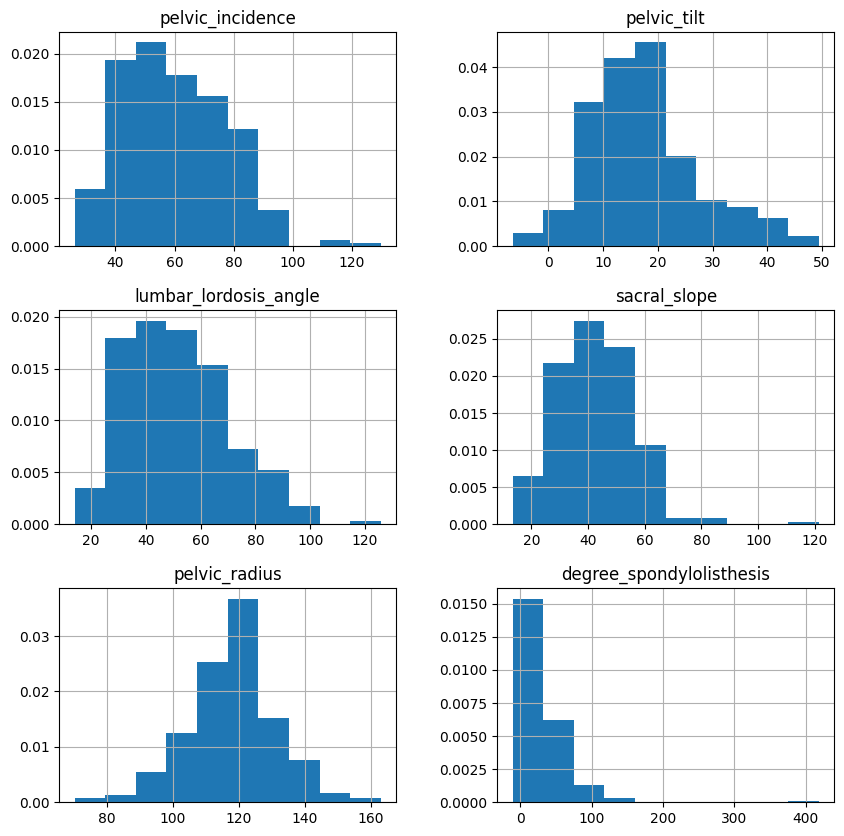

In [106]:
features.hist(figsize=(10,10),density=True)
plt.savefig('ex3_1_hist.png')
plt.show()

2- The dataset is not balanced, which can lead to a bias in the classifier.

In [107]:
df['class'].value_counts()
print(df['class'].value_counts())

class
Spondylolisthesis    150
Normal               100
Hernia                60
Name: count, dtype: int64


3- Check if variables are independent: correlation matrix

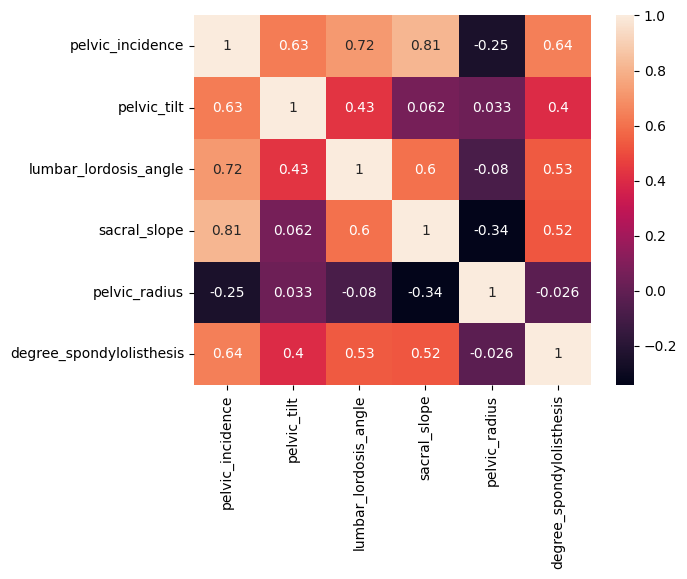

In [108]:
import seaborn as sns

df = df.drop('class', axis=1)
df.corr(method='pearson')
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.savefig('ex3_3_coormatrix.png')
plt.show()

As you can see, degree_spondylolisthesis is the variable that exhibits a distribution that least resembles a Gaussian. The count of Spondylolisthesis is more than double that of Hernia, which affects the probabilities of Naive Bayes (the classifier becomes biased). Finally, by observing the correlation matrix, it is possible to infer that some variables are correlated (correlation coefficient greater than 0.5).

These reasons pose challenges to the correct learning of the dataset.